In [1]:
!pip install -q timm pandas tqdm albumentations opencv-python scikit-learn transformers torch torchvision torchaudio
!pip install kaggle matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 250.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 264.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 228.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools # For optimizer params later
from tqdm.autonotebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt # For potential plotting, not explicitly used in core logic yet
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from collections import defaultdict # For metric calculation later
import numpy as np

/tmp/ipykernel_2919/916437689.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
# You can still switch between 'Flickr30k' and 'Flickr8k' to change datasets
SELECTED_DATASET = 'Flickr30k'
print(f"Dataset selected: {SELECTED_DATASET}")

'from google.colab import files\nfiles.upload()  # Upload kaggle.json manually\n!mkdir -p ~/.kaggle\n!mv kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json'

### Block 1: Flickr 8k&30k Data Preparation & Initial Setup  

In [ ]:
!apt update && apt install -y unzip
import os
import subprocess
import platform
from tqdm import tqdm
import sys
import zipfile
import requests # Import requests here

def detect_environment():
    try:
        import google.colab
        return "colab", "/content"
    except ImportError:
        pass
    if os.path.exists("/workspace") or "RUNPOD" in os.environ:
        return "runpod", "/workspace"
    return "local", os.getcwd()

def run_shell(cmd):
    print(f"🔧 {cmd}")
    subprocess.run(cmd, shell=True, check=True)

def download_with_progress(url, filename):
    # Ensure the directory for the file exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    import requests # Ensure requests is imported within the function scope if not globally
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(filename, 'wb') as file, tqdm(
        desc=f"⬇️  {filename}", total=total, unit='B', unit_scale=True
    ) as bar:
        for chunk in resp.iter_content(chunk_size=8192):
            file.write(chunk)
            bar.update(len(chunk))

def download_flickr8k(target_dir):
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    print("📥 Downloading Flickr8k...")
    zip_path = os.path.join(target_dir, "flickr8k.zip")
    url = "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
    download_with_progress(url, zip_path)
    run_shell(f"unzip -q {zip_path} -d {os.path.join(target_dir, 'flickr8k')}")
    os.remove(zip_path)

def download_flickr30k(target_dir):
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    print("📥 Downloading Flickr30k...")
    parts = [f"flickr30k_part0{i}" for i in range(3)]
    urls = [
        f"https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/{p}"
        for p in parts
    ]
    for url, part in zip(urls, parts):
        download_with_progress(url, os.path.join(target_dir, part))
    zip_path = os.path.join(target_dir, "flickr30k.zip")
    run_shell(f"cat {' '.join([os.path.join(target_dir, p) for p in parts])} > {zip_path}")
    for part in parts:
        os.remove(os.path.join(target_dir, part))
    run_shell(f"unzip -q {zip_path} -d {os.path.join(target_dir, 'flickr30k')}")
    os.remove(zip_path)

def main():
    env, root_dir = detect_environment()
    dataset_root = os.path.join(root_dir, "datasets")

    # Create the root dataset directory if it doesn't exist
    os.makedirs(dataset_root, exist_ok=True)

    #flickr8k_path = os.path.join(dataset_root, "flickr8k")
    #flickr30k_path = os.path.join(dataset_root, "flickr30k")

    print(f"🌎 Detected environment: {env.upper()}")
    print(f"📂 Target folder: {dataset_root}")

    if SELECTED_DATASET == 'Flickr30k':
        download_flickr30k(dataset_root)
    else:
        download_flickr8k(dataset_root)

    print("✅ All datasets downloaded and extracted successfully.")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"🚨 Error: {e}")
        # Removed sys.exit(1) to avoid the subsequent SystemExit traceback in interactive environments

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]       m
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1776 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]     
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:8 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.8 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [16

⬇️  /workspace/datasets/flickr8k.zip: 100%|██████████| 1.11G/1.11G [00:39<00:00, 28.0MB/s]


🔧 unzip -q /workspace/datasets/flickr8k.zip -d /workspace/datasets/flickr8k
✅ All datasets downloaded and extracted successfully.


In [ ]:
import os
import pandas as pd
import re
from collections import Counter

def clean_caption(text):
    text = str(text).lower().strip()
    text = re.sub(r"[^a-z0-9\s]", "", text)          # Remove punctuation
    text = re.sub(r"\s+", " ", text)                 # Normalize whitespace
    return text

def process_captions(dataset_dir, caption_file="captions.txt", dataset_name=""):
    input_path = os.path.join(dataset_dir, caption_file)
    if not os.path.exists(input_path): # datasets/flickr8k/captions.txt
        print(f"❌ Missing: {input_path}")
        return

    df = pd.read_csv(input_path, sep=None, engine="python")
    df.columns = df.columns.str.strip()
    df.rename(columns={"image_name": "image", "comment": "caption"}, inplace=True)
    df.dropna(subset=["caption"], inplace=True)
    df["caption"] = df["caption"].astype(str).str.strip().apply(clean_caption)
    df["num_tokens"] = df["caption"].apply(lambda x: len(x.split()))
    df = df[(df["num_tokens"] >= 3) & (df["num_tokens"] <= 50)].reset_index(drop=True)

    df["caption_number"] = df.groupby("image").cumcount()
    df["id"] = df["image"].factorize()[0]
    df = df[["image", "caption_number", "caption", "id"]]

    out_path = os.path.join(dataset_dir, f"{dataset_name}_captions_processed.csv")
    df.to_csv(out_path, index=False)

    print(f"\n✅ {dataset_name.upper()} DONE")
    print(f"📝 Total captions: {len(df)}")
    print(f"🔤 Avg length: {df['caption'].apply(lambda x: len(x.split())).mean():.2f} tokens")
    print(f"📄 Saved: {out_path}")

# --- Run for datasets ---
if SELECTED_DATASET == 'Flickr30k':
    process_captions("datasets/flickr8k", caption_file="captions.txt", dataset_name="flickr8k")
else:
    process_captions("datasets/flickr30k", caption_file="captions.txt", dataset_name="flickr30k")




✅ FLICKR8K DONE
📝 Total captions: 40428
🔤 Avg length: 10.80 tokens
📄 Saved: datasets/flickr8k/flickr8k_captions_processed.csv


In [ ]:
import os
import pandas as pd

def inspect_dataset(dataset_dir, processed_csv_name="captions_processed.csv", image_folder="Images", num_peek=5):
    print(f"\n🔍 Inspecting dataset at: {dataset_dir}")

    caption_files = [f for f in os.listdir(dataset_dir) if f.endswith(processed_csv_name)]
    if not caption_files:
        print("❌ Processed captions file not found.")
        return

    df = pd.read_csv(os.path.join(dataset_dir, caption_files[0]))
    img_dir = os.path.join(dataset_dir, image_folder)

    # Count image files
    num_files = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"🖼️ Total image files: {num_files}")

    # Unique images referenced
    unique_images = df['image'].nunique()
    print(f"🔗 Unique images in captions: {unique_images}")

    # Captions per image
    caption_counts = df.groupby('image').size().value_counts().sort_index()
    print("\n📊 Captions per image:")
    for k, v in caption_counts.items():
        print(f"   {k} captions: {v} images")

    # Preview captions
    print(f"\n🔎 First {num_peek} rows:")
    print(df.head(num_peek))

if SELECTED_DATASET == 'Flickr30k':
    inspect_dataset("datasets/flickr8k", "flickr8k_captions_processed.csv", "Images")
else:
    inspect_dataset("datasets/flickr30k", "flickr30k_captions_processed.csv", "Images")





🔍 Inspecting dataset at: datasets/flickr8k
🖼️ Total image files: 8091
🔗 Unique images in captions: 8091

📊 Captions per image:
   4 captions: 27 images
   5 captions: 8064 images

🔎 First 5 rows:
                       image  caption_number  \
0  1000268201_693b08cb0e.jpg               0   
1  1000268201_693b08cb0e.jpg               1   
2  1000268201_693b08cb0e.jpg               2   
3  1000268201_693b08cb0e.jpg               3   
4  1000268201_693b08cb0e.jpg               4   

                                             caption  id  
0  a child in a pink dress is climbing up a set o...   0  
1               a girl going into a wooden building    0  
2    a little girl climbing into a wooden playhouse    0  
3  a little girl climbing the stairs to her playh...   0  
4  a little girl in a pink dress going into a woo...   0  


### Block 2: CFG, Utility Classes, and Dataset Class

In [7]:
SELECTED_DATASET = "flickr8k" # "flickr30k" Or "flickr8k" depending on your choice
IMAGES_DIR_PATH = os.path.join("datasets", SELECTED_DATASET, "Images")
PROCESSED_CAPTIONS_CSV_PATH = os.path.join("datasets", SELECTED_DATASET, f"{SELECTED_DATASET}_captions_processed.csv")


class CFG:
    debug = False
    image_path = IMAGES_DIR_PATH               # Set dynamically in Block 1
    captions_path = "."
    processed_captions_file = PROCESSED_CAPTIONS_CSV_PATH # Set dynamically
    dataset_name = SELECTED_DATASET            # Store the selected dataset name

    batch_size = 64 #32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 2
    factor = 0.5
    epochs = 20 if not debug else 5 # Changed from 20 to 1 to test run in Colab
    gradient_accumulation_steps = 2
    early_stopping_patience = 3

    warmup_epochs = 2
    lr_min = 1e-6

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True
    trainable = True
    temperature = 0.07  # Common in contrastive learning (CLIP uses 0.01) #1.0
    size = 224
    num_projection_layers = 2 # Deeper projection #1
    projection_dim = 512 # Wider bottleneck
    dropout = 0.2 #0.1

cfg = CFG()

In [8]:
class AvgMeter:
    def __init__(self, name="Metric"): self.name, self.avg, self.sum, self.count = name, 0, 0, 0
    def reset(self): self.avg, self.sum, self.count = 0, 0, 0
    def update(self, val, count=1): self.count += count; self.sum += val * count; self.avg = self.sum / self.count if self.count > 0 else 0
    def __repr__(self): return f"{self.name}: {self.avg:.4f}"

def get_lr(optimizer): return optimizer.param_groups[0]['lr']

In [9]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            self.captions, padding=True, truncation=True, max_length=cfg.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        image_file_path = os.path.join(cfg.image_path, self.image_filenames[idx])
        try:
            image = cv2.imread(image_file_path)
            if image is None:
                # print(f"Warning: Failed to read image {image_file_path} at index {idx}. Using placeholder.")
                image = np.zeros((cfg.size, cfg.size, 3), dtype=np.uint8) # Placeholder

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transformed = self.transforms(image=image)
            image_tensor = transformed['image']

            if not isinstance(image_tensor, torch.Tensor):
                 image_tensor = torch.from_numpy(image_tensor)

            if image_tensor.ndim == 3 and image_tensor.shape[0] != 3 and image_tensor.shape[2] in [1, 3, 4]: # HWC check (common if ToTensorV2 not last)
                image_tensor = image_tensor.permute(2, 0, 1)

            item['image'] = image_tensor.float()
            item['caption_text'] = self.captions[idx]
        except Exception as e:
            print(f"Error processing item {idx}, image {image_file_path}: {e}")
            item['image'] = torch.zeros((3, cfg.size, cfg.size)).float() # Fallback image
            item['caption_text'] = "error placeholder caption"
             # Ensure tokenized keys still exist even if error
            if 'input_ids' not in item:
                 temp_tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
                 dummy_tokens = temp_tokenizer(item['caption_text'],padding="max_length",truncation=True,max_length=cfg.max_length, return_tensors="pt")
                 item.update({key: values[0] for key, values in dummy_tokens.items()})
        return item

    def __len__(self):
        return len(self.captions)

In [10]:
def get_transforms(mode="train"):
    """
    Returns a set of Albumentations transformations based on the mode.
    """
    if mode == "train":
        return A.Compose(
            [
                # The 'size' parameter with a tuple is kept, as it was the fix for a previous error
                A.RandomResizedCrop(size=(cfg.size, cfg.size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
                # FIX: Removed always_apply=True
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
                ToTensorV2(),
            ]
        )
    else:
        # "valid" or "test" mode
        return A.Compose(
            [
                # FIX: Removed always_apply=True
                A.Resize(height=cfg.size, width=cfg.size),
                # FIX: Removed always_apply=True
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
                ToTensorV2(),
            ]
        )

### Block 3: Model Architecture and Loss Function
  

In [11]:
class ImageEncoder(nn.Module):
    def __init__(
        self, model_name=cfg.model_name, pretrained=cfg.pretrained, trainable=cfg.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [12]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=cfg.text_encoder_model, pretrained=cfg.pretrained, trainable=cfg.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            # For non-pretrained, still use the config of the specified model to match dimensions etc.
            config = DistilBertConfig.from_pretrained(model_name)
            self.model = DistilBertModel(config=config)

        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0 # Index of CLS token

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :] # CLS token embedding

In [13]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim, # Input embedding dimension from the encoder
        projection_dim=cfg.projection_dim, # Output dimension (joint embedding space)
        dropout=cfg.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x_gelu = self.gelu(projected)
        x_fc = self.fc(x_gelu)
        x_dropout = self.dropout(x_fc)
        x_residual = x_dropout + projected # Residual connection
        x_norm = self.layer_norm(x_residual)
        return x_norm

In [14]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        # temperature parameter is removed from __init__ args
        image_embedding_dim=cfg.image_embedding,
        text_embedding_dim=cfg.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding_dim)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding_dim)

        # CHANGE 1: Implement a learnable temperature parameter (logit_scale)
        # This parameter will be learned during training.
        # The initial value is taken from the original CLIP paper.
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_image(self, image_tensor):
        image_features = self.image_encoder(image_tensor)
        image_embeddings = self.image_projection(image_features)
        return F.normalize(image_embeddings, p=2, dim=-1)

    def encode_text(self, input_ids, attention_mask):
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = self.text_projection(text_features)
        return F.normalize(text_embeddings, p=2, dim=-1)

    def forward(self, batch):
        image_embeddings = self.encode_image(batch["image"])
        text_embeddings = self.encode_text(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # CHANGE 2: Implement the standard InfoNCE Loss

        # Get the learnable temperature
        logit_scale = self.logit_scale.exp()

        # Calculate cosine similarity scores (logits)
        # The dot product of normalized embeddings is the cosine similarity
        logits_per_image = image_embeddings @ text_embeddings.T * logit_scale
        # For symmetry, we can just transpose the above matrix
        logits_per_text = logits_per_image.T

        # Create the ground-truth labels. For a batch of N pairs, the correct
        # text for image `i` is at index `i` (and vice-versa).
        batch_size = image_embeddings.shape[0]
        labels = torch.arange(batch_size, device=logits_per_image.device)

        # Calculate cross-entropy loss for both directions (image-to-text and text-to-image)
        # We use the built-in, highly optimized F.cross_entropy
        loss_img = F.cross_entropy(logits_per_image, labels)
        loss_txt = F.cross_entropy(logits_per_text, labels)

        # Average the two losses
        loss = (loss_img + loss_txt) / 2.0

        return loss

print("\nModel architecture classes (ImageEncoder, TextEncoder, ProjectionHead, CLIPModel) and loss function defined.")


Model architecture classes (ImageEncoder, TextEncoder, ProjectionHead, CLIPModel) and loss function defined.


### Block 4: Training Loop and Data Loaders Setup

In [15]:
def make_train_valid_dfs():
    captions_file_to_read = os.path.join(cfg.captions_path, cfg.processed_captions_file)
    print(f"Reading captions for train/valid split from: {captions_file_to_read}")
    try:
        dataframe = pd.read_csv(captions_file_to_read)
        if dataframe.empty:
            print("Error: Loaded dataframe for splitting is empty.")
            return pd.DataFrame(), pd.DataFrame()
    except FileNotFoundError:
        print(f"Error: Processed captions file not found at {captions_file_to_read}. Cannot create train/valid splits.")
        return pd.DataFrame(), pd.DataFrame()

    if "id" not in dataframe.columns or dataframe["id"].isnull().all():
        print("Error: 'id' column is missing or all null in the dataframe. Cannot split data by image ID.")
        return pd.DataFrame(), pd.DataFrame()

    valid_id_values = dataframe["id"].dropna().astype(int)
    if valid_id_values.empty:
        print("Error: No valid 'id' values found for splitting.")
        return pd.DataFrame(), pd.DataFrame()

    unique_image_ids_in_df = sorted(valid_id_values.unique())

    if cfg.debug:
        debug_max_unique_ids = min(20, len(unique_image_ids_in_df)) # e.g., 20 unique images for debug
        image_ids_to_split = unique_image_ids_in_df[:debug_max_unique_ids]
        print(f"Debug mode: Using {len(image_ids_to_split)} unique image IDs for train/valid split.")
    else:
        image_ids_to_split = unique_image_ids_in_df

    if not image_ids_to_split: # Check if list is empty
        print("No image IDs available for splitting after filtering (or in debug mode).")
        return pd.DataFrame(), pd.DataFrame()

    np.random.seed(42)
    num_valid_samples = int(0.2 * len(image_ids_to_split))
    if len(image_ids_to_split) > 0 and num_valid_samples == 0 : # Ensure at least 1 validation ID if possible
        num_valid_samples = 1
    if num_valid_samples > len(image_ids_to_split): # If 0.2*len is > len (only if len<5)
        num_valid_samples = max(0, len(image_ids_to_split) -1 ) # Ensure at least 1 train ID if possible


    valid_image_ids = np.random.choice(
        image_ids_to_split, size=num_valid_samples, replace=False
    )
    train_image_ids = [id_ for id_ in image_ids_to_split if id_ not in valid_image_ids]

    train_dataframe = dataframe[dataframe["id"].isin(train_image_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_image_ids)].reset_index(drop=True)

    print(f"Train DataFrame shape: {train_dataframe.shape} ({len(train_image_ids)} unique images)")
    print(f"Valid DataFrame shape: {valid_dataframe.shape} ({len(valid_image_ids)} unique images)")
    return train_dataframe, valid_dataframe


In [16]:
def build_loaders(dataframe, tokenizer, mode):
    if dataframe.empty or not all(col in dataframe.columns for col in ["image", "caption"]):
        print(f"Warning: DataFrame for mode '{mode}' is empty or missing key columns. Returning None for DataLoader.")
        return None

    transforms = get_transforms(mode=mode) # mode is "train" or "valid"/"test"
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    if len(dataset) == 0:
        print(f"Warning: Dataset for mode '{mode}' is empty after initialization. Returning None for DataLoader.")
        return None

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=True if mode == "train" else False,
        pin_memory=True if cfg.device == "cuda" else False
    )
    return dataloader


In [17]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, scheduler_step_mode):
    loss_meter = AvgMeter()
    model.train()
    tqdm_object = tqdm(train_loader, total=len(train_loader), desc="Training Epoch")

    # Reset gradients at the start of the epoch
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm_object):
        batch_on_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_on_device[k] = v.to(cfg.device)

        loss = model(batch_on_device)

        # Scale loss by accumulation steps to average the loss over the accumulated batches
        loss = loss / cfg.gradient_accumulation_steps

        # Accumulate gradients
        loss.backward()

        # Step the optimizer and scheduler only after accumulating enough gradients
        if (i + 1) % cfg.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad() # Reset gradients for the next accumulation cycle

            if scheduler_step_mode == "batch":
                if lr_scheduler is not None:
                    lr_scheduler.step()

        count = batch_on_device["image"].size(0)
        # We use loss.item() * accumulation_steps to log the "un-scaled" loss for readability
        loss_meter.update(loss.item() * cfg.gradient_accumulation_steps, count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    model.eval() # Ensure model is in evaluation mode
    tqdm_object = tqdm(valid_loader, total=len(valid_loader), desc=f"Validation Epoch")
    with torch.no_grad(): # No gradients needed for validation
        for batch in tqdm_object:
            batch_on_device = {}
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch_on_device[k] = v.to(cfg.device)

            loss = model(batch_on_device)

            count = batch_on_device["image"].size(0)
            loss_meter.update(loss.item(), count)
            tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [ ]:
import time
# The rest of the definitions from the original notebook (make_train_valid_dfs, build_loaders, train_epoch, valid_epoch) remain the same.

# --- Main Training Script Execution ---
print("\n--- Starting CLIP Model Training Process ---\n")

train_df, valid_df = make_train_valid_dfs()

if train_df.empty or valid_df.empty:
    print("Train or Valid DataFrame is empty after split. Halting training.")
else:
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    print("Tokenizer initialized.")
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    if train_loader is None or valid_loader is None:
        print("Failed to build DataLoaders. Halting training.")
    else:
        print("DataLoaders built successfully.")
        model = CLIPModel().to(cfg.device)
        print(f"CLIPModel initialized on {cfg.device}.")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total Trainable Parameters: {trainable_params:,}")

        params = [
            {"params": model.image_encoder.parameters(), "lr": cfg.image_encoder_lr, "weight_decay": 0.0},
            {"params": model.text_encoder.parameters(), "lr": cfg.text_encoder_lr, "weight_decay": 0.0},
            {"params": itertools.chain(
                model.image_projection.parameters(), model.text_projection.parameters()
            ), "lr": cfg.head_lr, "weight_decay": cfg.weight_decay}
        ]
        optimizer = torch.optim.AdamW(params)
        print("Optimizer: AdamW")

        from transformers import get_cosine_schedule_with_warmup
        num_training_steps = len(train_loader) * cfg.epochs
        num_warmup_steps = len(train_loader) * cfg.warmup_epochs
        lr_scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
        print("LR Scheduler: CosineAnnealingWithWarmup")
        scheduler_step_mode = "batch"

        print("\n--- Training Configuration ---")
        print(f"GPU Used: {torch.cuda.get_device_name(0) if cfg.device == 'cuda' else 'CPU'}")
        print(f"Batch Size: {cfg.batch_size}")
        print(f"Head LR: {cfg.head_lr}, Image Encoder LR: {cfg.image_encoder_lr}, Text Encoder LR: {cfg.text_encoder_lr}")

        best_loss = float('inf')
        best_epoch = -1
        epochs_without_improvement = 0
        training_history = {'train_loss': [], 'valid_loss': [], 'epoch_times': []}

        total_training_start_time = time.time()

        # Define the directory for saving checkpoints
        CHECKPOINT_DIR = f"./{SELECTED_DATASET}_checkpoints"
        os.makedirs(CHECKPOINT_DIR, exist_ok=True)


        # Define dataset-specific model checkpoint path within the new directory
        MODEL_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"best_model_{cfg.dataset_name}.pt")
        print(f"Model checkpoints will be saved to: {MODEL_CHECKPOINT_PATH}")

        for epoch in range(cfg.epochs):
            epoch_start_time = time.time()
            print(f"\nEpoch: {epoch + 1}/{cfg.epochs}")

            train_loss_meter = train_epoch(model, train_loader, optimizer, lr_scheduler, scheduler_step_mode)
            training_history['train_loss'].append(train_loss_meter.avg)

            valid_loss_meter = valid_epoch(model, valid_loader)
            training_history['valid_loss'].append(valid_loss_meter.avg)

            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            training_history['epoch_times'].append(epoch_duration)

            print(f"Epoch {epoch+1} Train Loss: {train_loss_meter.avg:.4f}, Valid Loss: {valid_loss_meter.avg:.4f}, LR: {get_lr(optimizer):.1e}")

            if valid_loss_meter.avg < best_loss:
                best_loss = valid_loss_meter.avg
                best_epoch = epoch + 1
                epochs_without_improvement = 0
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                }, MODEL_CHECKPOINT_PATH)
                print(f"Saved Best Model! Validation Loss: {best_loss:.4f}")
            else:
                epochs_without_improvement += 1
                print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

            if epochs_without_improvement >= cfg.early_stopping_patience:
                print(f"\nEarly stopping triggered after {cfg.early_stopping_patience} epochs without improvement.")
                break

        total_training_end_time = time.time()
        total_training_duration = total_training_end_time - total_training_start_time

        print("\n--- Training Complete ---")
        if best_epoch != -1:
            print(f"Best Validation Loss: {best_loss:.4f} achieved at Epoch {best_epoch}")
            print(f"Best model saved to: {MODEL_CHECKPOINT_PATH}")
        else:
            print("Training finished without saving a new best model.")


--- Starting CLIP Model Training Process ---

Reading captions for train/valid split from: ./datasets/flickr8k/flickr8k_captions_processed.csv
Train DataFrame shape: (32341, 4) (6473 unique images)
Valid DataFrame shape: (8087, 4) (1618 unique images)
Tokenizer initialized.
DataLoaders built successfully.
CLIPModel initialized on cuda.
Total Trainable Parameters: 91,841,089
Optimizer: AdamW
LR Scheduler: CosineAnnealingWithWarmup

--- Training Configuration ---
GPU Used: NVIDIA RTX A4000
Batch Size: 64
Head LR: 0.001, Image Encoder LR: 0.0001, Text Encoder LR: 1e-05
Model checkpoints will be saved to: ./checkpoints/best_model_flickr8k.pt

Epoch: 1/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.23it/s, valid_loss=2.4] 


Epoch 1 Train Loss: 2.6906, Valid Loss: 2.4049, LR: 2.5e-05
Saved Best Model! Validation Loss: 2.4049

Epoch: 2/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.21it/s, valid_loss=2.25]


Epoch 2 Train Loss: 1.2417, Valid Loss: 2.2546, LR: 5.0e-05
Saved Best Model! Validation Loss: 2.2546

Epoch: 3/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.24it/s, valid_loss=2.21]


Epoch 3 Train Loss: 0.8589, Valid Loss: 2.2057, LR: 7.5e-05
Saved Best Model! Validation Loss: 2.2057

Epoch: 4/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.23it/s, valid_loss=2.19]


Epoch 4 Train Loss: 0.6494, Valid Loss: 2.1853, LR: 1.0e-04
Saved Best Model! Validation Loss: 2.1853

Epoch: 5/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.25it/s, valid_loss=2.16]


Epoch 5 Train Loss: 0.5043, Valid Loss: 2.1559, LR: 1.0e-04
Saved Best Model! Validation Loss: 2.1559

Epoch: 6/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.25it/s, valid_loss=2.15]


Epoch 6 Train Loss: 0.3981, Valid Loss: 2.1514, LR: 9.9e-05
Saved Best Model! Validation Loss: 2.1514

Epoch: 7/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.22it/s, valid_loss=2.15]


Epoch 7 Train Loss: 0.3278, Valid Loss: 2.1528, LR: 9.8e-05
No improvement in validation loss for 1 epoch(s).

Epoch: 8/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.27it/s, valid_loss=2.14]


Epoch 8 Train Loss: 0.2873, Valid Loss: 2.1401, LR: 9.7e-05
Saved Best Model! Validation Loss: 2.1401

Epoch: 9/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.22it/s, valid_loss=2.16]


Epoch 9 Train Loss: 0.2519, Valid Loss: 2.1607, LR: 9.5e-05
No improvement in validation loss for 1 epoch(s).

Epoch: 10/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.32it/s, valid_loss=2.15]


Epoch 10 Train Loss: 0.2251, Valid Loss: 2.1493, LR: 9.3e-05
No improvement in validation loss for 2 epoch(s).

Epoch: 11/20


Validation Epoch: 100%|██████████| 127/127 [00:13<00:00,  9.28it/s, valid_loss=2.16]

Epoch 11 Train Loss: 0.2048, Valid Loss: 2.1565, LR: 9.1e-05
No improvement in validation loss for 3 epoch(s).

Early stopping triggered after 3 epochs without improvement.

--- Training Complete ---
Best Validation Loss: 2.1401 achieved at Epoch 8
Best model saved to: ./checkpoints/best_model_flickr8k.pt


Block 4.1: Training and Validation Loss

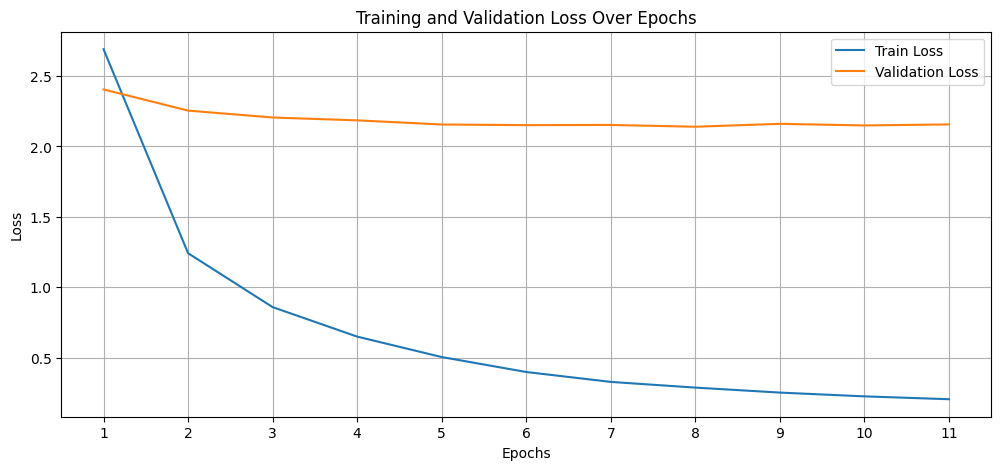

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(training_history['train_loss']) + 1), training_history['train_loss'], label='Train Loss')
plt.plot(range(1, len(training_history['valid_loss']) + 1), training_history['valid_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(training_history['train_loss']) + 1))
plt.legend()
plt.grid(True)
plt.show()

Block 4.2: Training Performance Summary

In [20]:
# Calculate performance metrics
total_epochs_trained = len(training_history['train_loss'])
avg_epoch_time = sum(training_history['epoch_times']) / len(training_history['epoch_times']) if training_history['epoch_times'] else 0
iterations_per_epoch = len(train_loader)
avg_iteration_time = avg_epoch_time / iterations_per_epoch if iterations_per_epoch > 0 else 0

# Display the summary
print("--- Training Performance Summary ---")
print(f"  GPU Used:                  {torch.cuda.get_device_name(0) if cfg.device == 'cuda' else 'CPU'}")
print(f"  Total Epochs Trained:      {total_epochs_trained}")
print(f"  Batch Size:                {cfg.batch_size}")
print(f"  Head Learning Rate:        {cfg.head_lr}")
print(f"  Image Encoder LR:          {cfg.image_encoder_lr}")
print(f"  Text Encoder LR:           {cfg.text_encoder_lr}")
print(f"  Optimizer:                 AdamW")
print("------------------------------------")
print(f"  Total Training Time:       {total_training_duration:.2f} seconds ({total_training_duration/60:.2f} minutes)")
print(f"  Average Time per Epoch:    {avg_epoch_time:.2f} seconds")
print(f"  Average Time per Iteration:{avg_iteration_time:.4f} seconds")
print("------------------------------------")

--- Training Performance Summary ---
  GPU Used:                  NVIDIA RTX A4000
  Total Epochs Trained:      11
  Batch Size:                64
  Head Learning Rate:        0.001
  Image Encoder LR:          0.0001
  Text Encoder LR:           1e-05
  Optimizer:                 AdamW
------------------------------------
  Total Training Time:       2118.99 seconds (35.32 minutes)
  Average Time per Epoch:    192.37 seconds
  Average Time per Iteration:0.3802 seconds
------------------------------------


### Block 5: Embedding Generation (After Training)

In [21]:
def generate_image_embeddings_dict(dataframe, model, transforms, cfg_obj_ref, image_column_name):
    """Generates embeddings for unique images in the dataframe."""
    unique_images = sorted(list(dataframe[image_column_name].unique()))
    embeddings = {}
    model.eval()
    tqdm_object = tqdm(unique_images, desc="Generating Image Embeddings")
    with torch.no_grad():
        for fname in tqdm_object:
            image_path = os.path.join(cfg_obj_ref.image_path, fname)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Could not read image {fname}, skipping.")
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_tensor = transforms(image=image)['image'].unsqueeze(0).to(cfg_obj_ref.device)
                embedding = model.encode_image(image_tensor)
                embeddings[fname] = embedding.squeeze(0).cpu()
            except Exception as e:
                print(f"Error processing image {fname}: {e}")
                continue
    return embeddings

def generate_text_embeddings_dict(dataframe, model, tokenizer, cfg_obj_ref, img_col, cap_num_col, cap_text_col):
    """Generates embeddings for all captions in the dataframe."""
    captions_data = []
    for _, r in dataframe.iterrows():
        caption_key = f"{r[img_col]}_cap_{r[cap_num_col]}"
        captions_data.append((caption_key, r[cap_text_col]))
    embeddings = {}
    model.eval()
    tqdm_object = tqdm(range(0, len(captions_data), cfg_obj_ref.batch_size), desc="Generating Text Embeddings")
    with torch.no_grad():
        for i in tqdm_object:
            batch_data = captions_data[i : i + cfg_obj_ref.batch_size]
            keys, texts = [item[0] for item in batch_data], [item[1] for item in batch_data]
            try:
                tokens = tokenizer(texts, padding=True, truncation=True, max_length=cfg_obj_ref.max_length, return_tensors="pt")
                embs = model.encode_text(tokens["input_ids"].to(cfg_obj_ref.device), tokens["attention_mask"].to(cfg_obj_ref.device))
                for k, e in zip(keys, embs):
                    embeddings[k] = e.cpu()
            except Exception as e:
                print(f"Error processing text batch starting with key {keys[0] if keys else 'N/A'}: {e}")
    return embeddings

In [22]:
print("\n--- Preparing for Embedding Generation (Post-Training) ---\n")

# Dynamically set the path to the best model based on the selected dataset
MODEL_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"best_model_{cfg.dataset_name}.pt")


if os.path.exists(MODEL_CHECKPOINT_PATH):
    loaded_model_for_embedding = CLIPModel().to(cfg.device)
    try:
        checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=cfg.device)
        loaded_model_for_embedding.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded successfully from {MODEL_CHECKPOINT_PATH}")
        loaded_model_for_embedding.eval()

        tokenizer_for_embedding = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
        image_transforms_for_embedding = get_transforms(mode="valid")

        EMBEDDINGS_OUTPUT_DIR = os.path.join(CHECKPOINT_DIR, "final_embeddings")
        os.makedirs(EMBEDDINGS_OUTPUT_DIR, exist_ok=True)

        # --- Generate Embeddings for the TRAINING Set ---
        if 'train_df' in locals() and not train_df.empty:
            print("\n--- Generating Embeddings for the TRAINING set ---")
            train_image_embeddings = generate_image_embeddings_dict(train_df, loaded_model_for_embedding, image_transforms_for_embedding, cfg, 'image')
            train_text_embeddings = generate_text_embeddings_dict(train_df, loaded_model_for_embedding, tokenizer_for_embedding, cfg, 'image', 'caption_number', 'caption')

            if train_image_embeddings:
                torch.save(train_image_embeddings, os.path.join(EMBEDDINGS_OUTPUT_DIR, f"train_image_embeddings_{cfg.dataset_name}.pt"))
            if train_text_embeddings:
                 torch.save(train_text_embeddings, os.path.join(EMBEDDINGS_OUTPUT_DIR, f"train_text_embeddings_{cfg.dataset_name}.pt"))
            print(f"Saved training embeddings to {EMBEDDINGS_OUTPUT_DIR}")

        # --- Generate Embeddings for the VALIDATION Set ---
        if 'valid_df' in locals() and not valid_df.empty:
            print("\n--- Generating Embeddings for the VALIDATION set ---")
            valid_image_embeddings = generate_image_embeddings_dict(valid_df, loaded_model_for_embedding, image_transforms_for_embedding, cfg, 'image')
            valid_text_embeddings = generate_text_embeddings_dict(valid_df, loaded_model_for_embedding, tokenizer_for_embedding, cfg, 'image', 'caption_number', 'caption')

            if valid_image_embeddings:
                torch.save(valid_image_embeddings, os.path.join(EMBEDDINGS_OUTPUT_DIR, f"valid_image_embeddings_{cfg.dataset_name}.pt"))
            if valid_text_embeddings:
                torch.save(valid_text_embeddings, os.path.join(EMBEDDINGS_OUTPUT_DIR, f"valid_text_embeddings_{cfg.dataset_name}.pt"))
            print(f"Saved validation embeddings to {EMBEDDINGS_OUTPUT_DIR}")

    except Exception as e:
        print(f"Error loading model or generating embeddings: {e}")
        loaded_model_for_embedding = None
else:
    print(f"Model checkpoint {MODEL_CHECKPOINT_PATH} not found. Cannot generate embeddings.")


--- Preparing for Embedding Generation (Post-Training) ---

Model loaded successfully from ./checkpoints/best_model_flickr8k.pt

--- Generating Embeddings for the TRAINING set ---


Generating Text Embeddings: 100%|██████████| 506/506 [00:15<00:00, 31.66it/s]


Saved training embeddings to ./checkpoints/final_embeddings

--- Generating Embeddings for the VALIDATION set ---


Generating Text Embeddings: 100%|██████████| 127/127 [00:03<00:00, 32.25it/s]


Saved validation embeddings to ./checkpoints/final_embeddings


### Block 6: Quantitative Results - Retrieval Scores (Using Dumped Embeddings)

In [23]:
print("\n--- Preparing for Retrieval Accuracy Calculation ---")

# Top-K values for evaluation
TOP_K_VALUES_EVAL = list(range(1, 6)) # k from 1 to 5

# --- Metric Helper Functions (should be defined if not already in scope from Block 2) ---
# Assuming AvgMeter, get_lr are defined. We need compute_top_k_metrics, etc. for retrieval.

def compute_top_k_retrieval_metrics(ranked_keys, ground_truth_keys, current_top_k_values_list):
    result = {k: {"accuracy": 0, "precision": 0, "recall": 0} for k in current_top_k_values_list}
    ground_truth_set = set(ground_truth_keys)
    if not ground_truth_set:
        return result # All metrics remain 0
    for k_val in current_top_k_values_list:
        top_k = ranked_keys[:k_val]
        hits = len(set(top_k) & ground_truth_set)
        result[k_val]["accuracy"] = 1 if hits > 0 else 0
        result[k_val]["precision"] = hits / k_val if k_val > 0 else 0
        result[k_val]["recall"] = hits / len(ground_truth_set)
    return result

def accumulate_retrieval_metrics(overall_metrics_dict, current_query_metrics_dict):
    for k_val in current_query_metrics_dict:
        for metric_name in current_query_metrics_dict[k_val]:
            overall_metrics_dict[k_val][metric_name] += current_query_metrics_dict[k_val][metric_name]

def init_retrieval_metrics_accumulator(current_top_k_values_list):
    return {k: {"accuracy": 0, "precision": 0, "recall": 0} for k in current_top_k_values_list}

def report_retrieval_metrics(title, accumulated_metrics_dict, total_valid_queries_count, current_top_k_values_list):
    print(f"\n--- {title} ---")
    print(f"Total Queries: {total_valid_queries_count}")
    if total_valid_queries_count == 0:
        print("No valid queries were processed.")
        return

    # NEW: Create a more readable table format
    header = f"| {'Top-K':<5} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} |"
    print(header)
    print("|" + "-" * (len(header) - 2) + "|")

    for k_val in current_top_k_values_list:
        acc = accumulated_metrics_dict[k_val]["accuracy"] / total_valid_queries_count
        prec = accumulated_metrics_dict[k_val]["precision"] / total_valid_queries_count
        rec = accumulated_metrics_dict[k_val]["recall"] / total_valid_queries_count
        row = f"| {k_val:<5} | {acc:<10.4f} | {prec:<10.4f} | {rec:<10.4f} |"
        print(row)
    print("-" * len(header))


--- Preparing for Retrieval Accuracy Calculation ---


In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.autonotebook import tqdm
from collections import defaultdict


# --- Main Evaluation Function using Loaded Embeddings ---
def run_final_retrieval_evaluation(
    title_prefix,
    image_embeddings_dict_loaded,
    text_embeddings_dict_loaded,
    top_k_list,
    calc_device="cpu" # Device for cosine similarity calculation
):
    """
    This is the corrected function definition. It now accepts 'title_prefix'.
    """
    if not image_embeddings_dict_loaded or not text_embeddings_dict_loaded:
        print("Error: Loaded image or text embeddings dictionary is empty. Cannot proceed with evaluation.")
        return

    print("Preparing matrices for final evaluation...")
    image_ids_eval_list = list(image_embeddings_dict_loaded.keys())
    img_matrix_list = [image_embeddings_dict_loaded[id_].unsqueeze(0).to(calc_device) if image_embeddings_dict_loaded[id_].ndim==1 else image_embeddings_dict_loaded[id_].to(calc_device) for id_ in image_ids_eval_list]
    image_matrix_eval = torch.cat(img_matrix_list, dim=0).cpu().numpy()

    caption_keys_eval_list = list(text_embeddings_dict_loaded.keys())
    txt_matrix_list = [text_embeddings_dict_loaded[id_].unsqueeze(0).to(calc_device) if text_embeddings_dict_loaded[id_].ndim==1 else text_embeddings_dict_loaded[id_].to(calc_device) for id_ in caption_keys_eval_list]
    text_matrix_eval = torch.cat(txt_matrix_list, dim=0).cpu().numpy()

    print(f"Evaluation Image matrix shape: {image_matrix_eval.shape}")
    print(f"Evaluation Text matrix shape: {text_matrix_eval.shape}")

    gt_img_to_capkeys = defaultdict(list)
    gt_capkey_to_imgid = {}
    for cap_key in caption_keys_eval_list:
        try:
            img_id_part = cap_key.split('_cap_')[0]
            gt_img_to_capkeys[img_id_part].append(cap_key)
            gt_capkey_to_imgid[cap_key] = img_id_part
        except IndexError: continue
    print(f"Built GT map for {len(gt_img_to_capkeys)} images for evaluation.")

    # 1. Image -> Text Retrieval
    if image_matrix_eval.size > 0 and text_matrix_eval.size > 0:
        i2t_metrics = init_retrieval_metrics_accumulator(top_k_list)
        i2t_queries = 0
        for idx, img_id in enumerate(tqdm(image_ids_eval_list, desc="Eval: Img2Txt")):
            if img_id not in gt_img_to_capkeys: continue
            query_img_vec = image_matrix_eval[idx].reshape(1, -1)
            sims = cosine_similarity(query_img_vec, text_matrix_eval)[0]
            ranked_indices = np.argsort(sims)[::-1]
            ranked_caps = [caption_keys_eval_list[i] for i in ranked_indices]
            gt_caps = gt_img_to_capkeys[img_id]
            metrics = compute_top_k_retrieval_metrics(ranked_caps, gt_caps, top_k_list)
            accumulate_retrieval_metrics(i2t_metrics, metrics)
            i2t_queries += 1
        report_retrieval_metrics(f"{title_prefix}: Image-to-Text Retrieval", i2t_metrics, i2t_queries, top_k_list)

    # 2. Text -> Text Retrieval
    if text_matrix_eval.size > 0:
        t2t_metrics = init_retrieval_metrics_accumulator(top_k_list)
        t2t_queries = 0
        for idx, cap_key_query in enumerate(tqdm(caption_keys_eval_list, desc="Eval: Txt2Txt")):
            img_id_query = gt_capkey_to_imgid.get(cap_key_query)
            if not img_id_query: continue
            query_txt_vec = text_matrix_eval[idx].reshape(1, -1)
            sims = cosine_similarity(query_txt_vec, text_matrix_eval)[0]
            sims[idx] = -1e9 # Exclude self
            ranked_indices = np.argsort(sims)[::-1]
            ranked_caps = [caption_keys_eval_list[i] for i in ranked_indices]
            gt_caps = [ck for ck in gt_img_to_capkeys.get(img_id_query, []) if ck != cap_key_query]
            metrics = compute_top_k_retrieval_metrics(ranked_caps, gt_caps, top_k_list)
            accumulate_retrieval_metrics(t2t_metrics, metrics)
            t2t_queries +=1
        report_retrieval_metrics(f"{title_prefix}: Text-to-Text Retrieval", t2t_metrics, t2t_queries, top_k_list)

    # 3. Text -> Image Retrieval
    if text_matrix_eval.size > 0 and image_matrix_eval.size > 0:
        t2i_metrics = init_retrieval_metrics_accumulator(top_k_list)
        t2i_queries = 0
        for idx, cap_key_query in enumerate(tqdm(caption_keys_eval_list, desc="Eval: Txt2Img")):
            gt_img_id = gt_capkey_to_imgid.get(cap_key_query)
            if not gt_img_id or gt_img_id not in image_ids_eval_list : continue
            query_txt_vec = text_matrix_eval[idx].reshape(1, -1)
            sims = cosine_similarity(query_txt_vec, image_matrix_eval)[0]
            ranked_indices = np.argsort(sims)[::-1]
            ranked_imgs = [image_ids_eval_list[i] for i in ranked_indices]
            metrics = compute_top_k_retrieval_metrics(ranked_imgs, [gt_img_id], top_k_list)
            accumulate_retrieval_metrics(t2i_metrics, metrics)
            t2i_queries += 1
        report_retrieval_metrics(f"{title_prefix}: Text-to-Image Retrieval", t2i_metrics, t2i_queries, top_k_list)
    print("\n✅ Final Retrieval Accuracy Calculation Complete.")

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
# --- Example Usage of Final Evaluation (after Block 5 saves embeddings) ---
if __name__ == '__main__': # This check ensures this part only runs when script is executed directly

    # Get the dataset name from the config to dynamically load files
    dataset_name = cfg.dataset_name
    # The embeddings are saved in checkpoints/final_embeddings,
    # not in a dataset-named folder within the current directory.
    CHECKPOINT_EMBEDDINGS_DIR = os.path.join("./checkpoints", "final_embeddings")


    print(f"\n--- Running Final Retrieval Accuracy Calculation for {dataset_name} ---\n")

    # --- VALIDATION SET EVALUATION ---
    print("--- 1. Evaluating Validation Set ---")
    # Corrected paths to point to the actual save location
    SAVED_IMG_EMB_PATH_VALID = os.path.join(CHECKPOINT_EMBEDDINGS_DIR, f"valid_image_embeddings_{dataset_name}.pt")
    SAVED_TXT_EMB_PATH_VALID = os.path.join(CHECKPOINT_EMBEDDINGS_DIR, f"valid_text_embeddings_{dataset_name}.pt")


    loaded_valid_image_embeddings = {}
    loaded_valid_text_embeddings = {}

    if os.path.exists(SAVED_IMG_EMB_PATH_VALID):
        loaded_valid_image_embeddings = torch.load(SAVED_IMG_EMB_PATH_VALID, map_location='cpu')
        print(f"Loaded {len(loaded_valid_image_embeddings)} final VALIDATION image embeddings.")
    else:
        print(f"Error: Final VALIDATION Image embeddings file not found at {SAVED_IMG_EMB_PATH_VALID}.")

    if os.path.exists(SAVED_TXT_EMB_PATH_VALID):
        loaded_valid_text_embeddings = torch.load(SAVED_TXT_EMB_PATH_VALID, map_location='cpu')
        print(f"Loaded {len(loaded_valid_text_embeddings)} final VALIDATION text embeddings.")
    else:
        print(f"Error: Final VALIDATION Text embeddings file not found at {SAVED_TXT_EMB_PATH_VALID}.")

    if loaded_valid_image_embeddings and loaded_valid_text_embeddings:
        run_final_retrieval_evaluation(
            title_prefix="Validation Set",
            image_embeddings_dict_loaded=loaded_valid_image_embeddings,
            text_embeddings_dict_loaded=loaded_valid_text_embeddings,
            top_k_list=TOP_K_VALUES_EVAL,
            calc_device=cfg.device
        )
    else:
        print("Cannot run final evaluation for VALIDATION set due to missing loaded embeddings.")

    # --- TRAINING SET VERIFICATION (NO EVALUATION) ---
    print("\n--- 2. Verifying Training Set Embeddings (No Evaluation) ---")
    # Assuming CHECKPOINT_DIR is defined and is the base directory for saved files
    SAVED_IMG_EMB_PATH_TRAIN = os.path.join(CHECKPOINT_DIR, "final_embeddings", f"train_image_embeddings_{cfg.dataset_name}.pt")
    SAVED_TXT_EMB_PATH_TRAIN = os.path.join(CHECKPOINT_DIR, "final_embeddings", f"train_text_embeddings_{cfg.dataset_name}.pt")

    if os.path.exists(SAVED_IMG_EMB_PATH_TRAIN):
        loaded_train_image_embeddings = torch.load(SAVED_IMG_EMB_PATH_TRAIN, map_location='cpu')
        print(f"Verified: Found and loaded {len(loaded_train_image_embeddings)} TRAINING image embeddings.")
    else:
        print(f"Error: Final TRAINING Image embeddings file not found at {SAVED_IMG_EMB_PATH_TRAIN}.")

    if os.path.exists(SAVED_TXT_EMB_PATH_TRAIN):
        loaded_train_text_embeddings = torch.load(SAVED_TXT_EMB_PATH_TRAIN, map_location='cpu')
        print(f"Verified: Found and loaded {len(loaded_train_text_embeddings)} TRAINING text embeddings.")
    else:
        print(f"Error: Final TRAINING Text embeddings file not found at {SAVED_TXT_EMB_PATH_TRAIN}.")

    print("\nSkipping accuracy evaluation for the training set as requested.")


--- Running Final Retrieval Accuracy Calculation for flickr8k ---

--- 1. Evaluating Validation Set ---
Loaded 1618 final VALIDATION image embeddings.
Loaded 8087 final VALIDATION text embeddings.
Preparing matrices for final evaluation...
Evaluation Image matrix shape: (1618, 512)
Evaluation Text matrix shape: (8087, 512)
Built GT map for 1618 images for evaluation.


Eval: Img2Txt: 100%|██████████| 1618/1618 [01:50<00:00, 14.59it/s]



--- Validation Set: Image-to-Text Retrieval ---
Total Queries: 1618
| Top-K | Accuracy   | Precision  | Recall     |
|----------------------------------------------|
| 1     | 0.2880     | 0.2880     | 0.0576     |
| 2     | 0.4116     | 0.2747     | 0.1099     |
| 3     | 0.4759     | 0.2530     | 0.1519     |
| 4     | 0.5272     | 0.2373     | 0.1900     |
| 5     | 0.5674     | 0.2222     | 0.2223     |
------------------------------------------------


Eval: Txt2Txt: 100%|██████████| 8087/8087 [08:22<00:00, 16.08it/s]



--- Validation Set: Text-to-Text Retrieval ---
Total Queries: 8087
| Top-K | Accuracy   | Precision  | Recall     |
|----------------------------------------------|
| 1     | 0.5631     | 0.5631     | 0.1408     |
| 2     | 0.6598     | 0.5062     | 0.2532     |
| 3     | 0.7171     | 0.4535     | 0.3402     |
| 4     | 0.7552     | 0.4034     | 0.4035     |
| 5     | 0.7850     | 0.3551     | 0.4440     |
------------------------------------------------


Eval: Txt2Img: 100%|██████████| 8087/8087 [02:52<00:00, 46.83it/s]



--- Validation Set: Text-to-Image Retrieval ---
Total Queries: 8087
| Top-K | Accuracy   | Precision  | Recall     |
|----------------------------------------------|
| 1     | 0.2124     | 0.2124     | 0.2124     |
| 2     | 0.3180     | 0.1590     | 0.3180     |
| 3     | 0.3933     | 0.1311     | 0.3933     |
| 4     | 0.4534     | 0.1134     | 0.4534     |
| 5     | 0.4956     | 0.0991     | 0.4956     |
------------------------------------------------

✅ Final Retrieval Accuracy Calculation Complete.

--- 2. Verifying Training Set Embeddings (No Evaluation) ---
Verified: Found and loaded 6473 TRAINING image embeddings.
Verified: Found and loaded 32341 TRAINING text embeddings.

Skipping accuracy evaluation for the training set as requested.


### Block 7: Qualitative Retrieval Analysis

--- Qualitative Example: Image-to-Text Retrieval ---


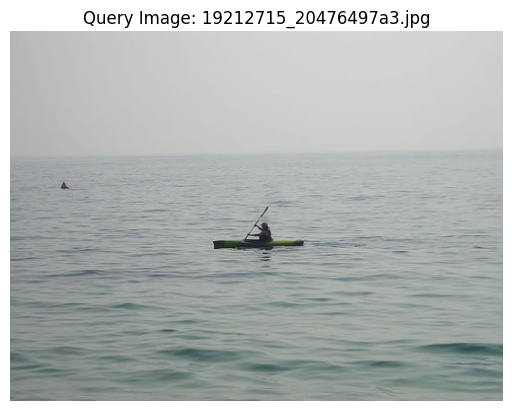

Top 5 Retrieved Captions:
  - (Score: 0.7385) a man in a rowboat is rowing across blue water 
  - (Score: 0.7101) a person kayaking in the ocean 
  - (Score: 0.7000) a man in a blue canoe battling through rough waves
  - (Score: 0.6967) a person kayaks in the middle of the ocean on a grey day 
  - (Score: 0.6931) a man in a yellow boat paddling down rough waters 

--- Qualitative Example: Text-to-Image Retrieval ---
Query Caption: "two young boys are climbing over the seat in a vehicle "


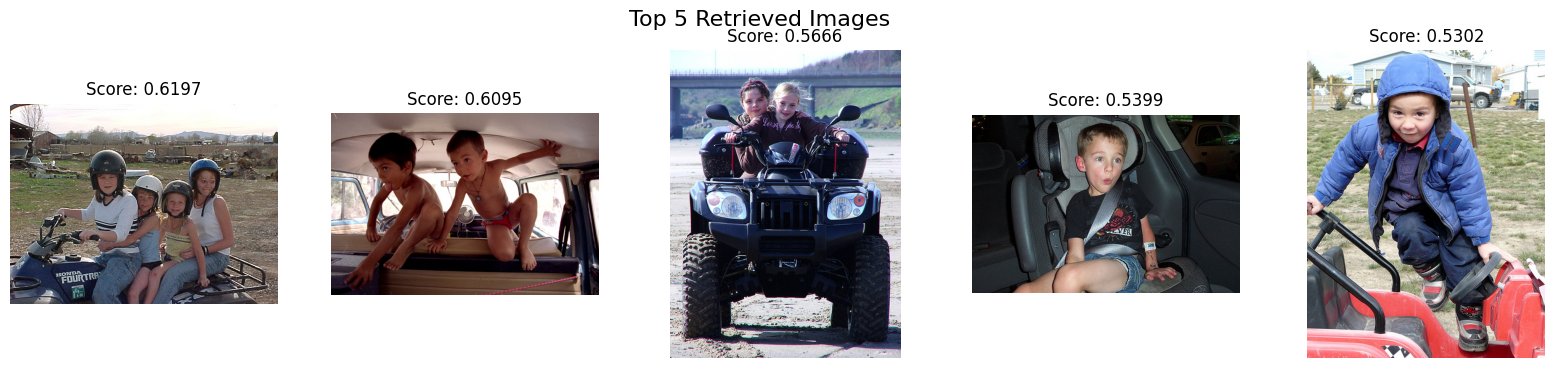


--- Qualitative Example: Text-to-Text Retrieval ---
Query Caption: "two young boys are climbing over the seat in a vehicle "

Top 5 Retrieved Captions (from other images):
  - (Score: 0.8722) two children climb into the back of a vehicle from the front seat 
  - (Score: 0.8674) two young boys wearing just underwear climb around a vehicle 
  - (Score: 0.7945) a man and boy sit in the driver seat 
  - (Score: 0.7943) a young boy sits on the lap of a man behind the wheel of a vehicle 
  - (Score: 0.7909) two children in swim trunks climb through a car


In [26]:
import random
from PIL import Image

def find_best_matches(query_embedding, candidate_embeddings_dict, k=5):
    """Finds the top k matches for a query embedding from a dictionary of candidate embeddings."""
    candidate_keys = list(candidate_embeddings_dict.keys())
    candidate_matrix = torch.stack(list(candidate_embeddings_dict.values())).to(cfg.device)

    # Normalize embeddings before calculating cosine similarity
    query_embedding = F.normalize(query_embedding, p=2, dim=-1)
    candidate_matrix = F.normalize(candidate_matrix, p=2, dim=-1)

    # Compute cosine similarity
    similarity_scores = (query_embedding @ candidate_matrix.T).squeeze(0)

    # Get top k results
    top_k_scores, top_k_indices = torch.topk(similarity_scores, k=k)

    return [(candidate_keys[i], top_k_scores[j].item()) for j, i in enumerate(top_k_indices)]

# --- Image to Text Retrieval Example ---
print("--- Qualitative Example: Image-to-Text Retrieval ---")
if 'valid_df' in locals() and not valid_df.empty and 'loaded_valid_image_embeddings' in locals() and 'loaded_valid_text_embeddings' in locals():
    # Select a random image from the validation set
    random_image_name = random.choice(list(loaded_valid_image_embeddings.keys()))
    query_image_embedding = loaded_valid_image_embeddings[random_image_name].unsqueeze(0).to(cfg.device)

    # Find best text matches
    text_matches = find_best_matches(query_image_embedding, loaded_valid_text_embeddings, k=5)

    # Display the query image
    image_path = os.path.join(cfg.image_path, random_image_name)
    image_display = Image.open(image_path)
    plt.imshow(image_display)
    plt.title(f"Query Image: {random_image_name}")
    plt.axis('off')
    plt.show()

    # Display results
    print("Top 5 Retrieved Captions:")
    for text_key, score in text_matches:
        # Extract original caption text from the key
        img_id, cap_num_str = text_key.split('_cap_')
        cap_num = int(cap_num_str)
        caption_text = valid_df[(valid_df['image'] == img_id) & (valid_df['caption_number'] == cap_num)]['caption'].iloc[0]
        print(f"  - (Score: {score:.4f}) {caption_text}")
else:
    print("Skipping image-to-text qualitative analysis: data/embeddings not available.")

# --- Text to Image Retrieval Example ---
print("\n--- Qualitative Example: Text-to-Image Retrieval ---")
if 'valid_df' in locals() and not valid_df.empty and 'loaded_valid_image_embeddings' in locals() and 'loaded_valid_text_embeddings' in locals():
    # Select a random caption from the validation set
    random_caption_key = random.choice(list(loaded_valid_text_embeddings.keys()))
    query_text_embedding = loaded_valid_text_embeddings[random_caption_key].unsqueeze(0).to(cfg.device)

    # Extract original caption text for display
    img_id_q, cap_num_str_q = random_caption_key.split('_cap_')
    cap_num_q = int(cap_num_str_q)
    query_caption_text = valid_df[(valid_df['image'] == img_id_q) & (valid_df['caption_number'] == cap_num_q)]['caption'].iloc[0]

    print(f"Query Caption: \"{query_caption_text}\"")

    # Find best image matches
    image_matches = find_best_matches(query_text_embedding, loaded_valid_image_embeddings, k=5)

    # Display results
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle("Top 5 Retrieved Images", fontsize=16)
    for i, (img_name, score) in enumerate(image_matches):
        img_path = os.path.join(cfg.image_path, img_name)
        axes[i].imshow(Image.open(img_path))
        axes[i].set_title(f"Score: {score:.4f}")
        axes[i].axis('off')
    plt.show()

else:
    print("Skipping text-to-image qualitative analysis: data/embeddings not available.")

# --- Text to Text Retrieval Example ---
print("\n--- Qualitative Example: Text-to-Text Retrieval ---")
if 'valid_df' in locals() and not valid_df.empty and 'loaded_valid_text_embeddings' in locals():
    # Select a random caption (can reuse the one from T2I)
    print(f"Query Caption: \"{query_caption_text}\"")

    # Exclude the query caption itself from the candidates
    candidate_texts = {k: v for k, v in loaded_valid_text_embeddings.items() if k != random_caption_key}

    # Find best text matches
    text_matches = find_best_matches(query_text_embedding, candidate_texts, k=5)

    # Display results
    print("\nTop 5 Retrieved Captions (from other images):")
    for text_key, score in text_matches:
        img_id, cap_num_str = text_key.split('_cap_')
        cap_num = int(cap_num_str)
        caption_text = valid_df[(valid_df['image'] == img_id) & (valid_df['caption_number'] == cap_num)]['caption'].iloc[0]
        print(f"  - (Score: {score:.4f}) {caption_text}")
else:
    print("Skipping text-to-text qualitative analysis: data/embeddings not available.")

In [29]:
!pip install --quiet pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # This opens a browser for authentication
drive = GoogleDrive(gauth)

import os

# Set this to your RunPod local directory
local_directory = "/workspace/checkpoints"

# Optional: specify Google Drive folder ID (get it from URL)
# If None, files go to "My Drive"
google_drive_folder_id = '1zphetlD_-dL2veJEiNaQF3s8xEsO-CzFolder_id'  # or None

for root, _, files in os.walk(local_directory):
    for filename in files:
        local_file_path = os.path.join(root, filename)
        relative_path = os.path.relpath(local_file_path, local_directory)
        
        file_metadata = {
            'title': relative_path
        }
        if google_drive_folder_id:
            file_metadata['parents'] = [{'id': google_drive_folder_id}]
        
        gfile = drive.CreateFile(file_metadata)
        gfile.SetContentFile(local_file_path)
        gfile.Upload()
        print(f"Uploaded: {relative_path}")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=1054008852018-jbel4os6ef7dvgcq1ujtt4j8cpdtkdob.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



KeyboardInterrupt: 

In [ ]:
!pip freeze > "./requirements.txt"